In [1]:
import numpy as np 
import pandas as pd
import math
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
def import_data():
 data = pd.read_csv('norway_new_car_sales_by_make.csv')
 
 data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
 
 df = pd.pivot_table(data=data,values='Quantity',index='Make',columns='Period',aggfunc='sum',fill_value=0)
 return df

In [3]:
def datasets(df, x_len=12, y_len=1, test_loops=12):
 D = df.values
 rows, periods = D.shape
 # Training set creation
 loops = periods + 1- x_len- y_len
 train = []
 for col in range(loops):
    train.append(D[:,col:col+x_len+y_len])
 
 train = np.vstack(train)
 print(train.shape)
 X_train, Y_train = np.split(train,[-y_len],axis=1)
 # Test set creation
 if test_loops > 0:
    X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)

    Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
 else: # No test set: X_test is used to generate the future forecast
    X_test = D[:,-x_len:]
    Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value
 # Formatting required for scikit-learn
 if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()
 return X_train, Y_train, X_test, Y_test

In [4]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name=''):
 df = pd.DataFrame(columns = ['MAE','RMSE','Bias'],index=['Train','Test'])
 df.index.name = name
 
 df.loc['Train','MAE'] = 100*np.mean(abs(Y_train-Y_train_pred))/np.mean(Y_train)

 df.loc['Train','RMSE'] = 100*np.sqrt(np.mean((Y_train-Y_train_pred)**2))/np.mean(Y_train)
 
 df.loc['Train','Bias'] = 100*np.mean((Y_train- Y_train_pred))/np.mean(Y_train)

 df.loc['Test','MAE'] = 100*np.mean(abs(Y_test- Y_test_pred))/np.mean(Y_test)
 
 df.loc['Test','RMSE'] = 100*np.sqrt(np.mean((Y_test-Y_test_pred)**2))/np.mean(Y_test)
 
 df.loc['Test','Bias'] = 100*np.mean((Y_test- Y_test_pred))/np.mean(Y_test)
 df = df.astype(float).round(1) #Round number for display
 print(df)

In [5]:
df = import_data()
X_train, Y_train, X_test, Y_test = datasets(df, x_len=12, y_len=1,test_loops=12)

(7085, 13)


In [9]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
  Using cached xgboost-2.0.3-py3-none-win_amd64.whl.metadata (2.0 kB)
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 326.8 kB/s eta 0:05:06
   ---------------------------------------- 0.1/99.8 MB 508.4 kB/s eta 0:03:17
   ---------------------------------------- 0.1/99.8 MB 708.1 kB/s eta 0:02:21
   ---------------------------------------- 0.3/99.8 MB 1.1 MB/s eta 0:01:28
   ---------------------------------------- 0.5/99.8 MB 1.6 MB/s eta 0:01:01
   ---------------------------------------- 0.5/99.8 MB 1.8 MB/s eta 0:00:57
   ---------------------------------------- 1.0/99.8 MB 2.6 MB/s eta 0:00:38
    ------------------------------------

In [10]:
from xgboost.sklearn import XGBRegressor
XGB = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
XGB = XGB.fit(X_train, Y_train)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

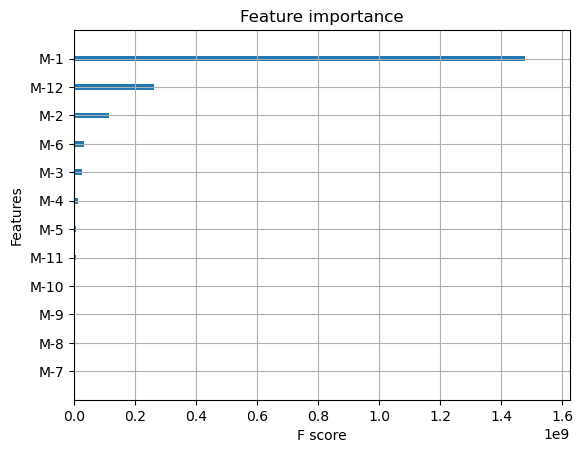

In [12]:
import xgboost as xgb
XGB.get_booster().feature_names = [f'M{x-12}' for x in range(12)]
xgb.plot_importance(XGB, importance_type='total_gain', show_values=False)

In [24]:
params = {'max_depth': [5,6,7,8,10,11],
'learning_rate': [0.005,0.01,0.025,0.05,0.1,0.15],
'colsample_bynode': [0.5,0.6,0.7,0.8,0.9,1.0],#max_features
'colsample_bylevel': [0.8,0.9,1.0],
'colsample_bytree': [0.6,0.7,0.8,0.9,1.0],
'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7],#max_samples
'min_child_weight': [5,10,15,20,25],#min_samples_leaf
'reg_alpha': [1,5,10,20,50],
'reg_lambda': [0.01,0.05,0.1,0.5,1],
'n_estimators':[1000]}

In [15]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.15)
fit_params = {'early_stopping_rounds':25,
'eval_set':[(x_val, y_val)],
'eval_metric':'mae',
'verbose':False}

XGB = XGBRegressor(n_jobs=1)
XGB_cv = RandomizedSearchCV(XGB, params, cv=5, n_jobs=-1, verbose=1,n_iter=1000, scoring='neg_mean_absolute_error')

XGB_cv.fit(x_train, y_train,**fit_params)
print('Tuned XGBoost Parameters:',XGB_cv.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


d:\Conda\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
d:\Conda\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Tuned XGBoost Parameters: {'subsample': 0.2, 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.6, 'colsample_bynode': 0.8, 'colsample_bylevel': 1.0}


In [26]:

best_params = XGB_cv.best_params_
XGB = XGBRegressor(n_jobs=-1, **best_params)
XGB = XGB.fit(x_train, y_train, **fit_params)
print(f'Best iteration: {XGB.get_booster().best_iteration}')
print(f'Best score: {XGB.get_booster().best_score}')
Y_train_pred = XGB.predict(X_train)
Y_test_pred = XGB.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='XGBoost')

Best iteration: 639
Best score: 32.951694742569714
          MAE  RMSE  Bias
XGBoost                  
Train    14.2  35.0   0.1
Test     17.5  43.2   2.1
